# [A continuous identity verification method based on free-text keystroke dynamics](http://ieeexplore.ieee.org.proxy1.lib.uwo.ca/document/7844242/authors)

In [1]:
import psycopg2
import pandas as pd
import sys
sys.path.append("..")
import credentials
import numpy as np
from datetime import datetime
import time
import string
from tqdm import tnrange, tqdm_notebook, tqdm
from tqdm._tqdm_notebook import tqdm_notebook
import numpy.ma as ma
from multiprocessing import Pool
from scipy.optimize import minimize
from biokey.data import DataInterface
import biokey.tools
from biokey.tools import parallel_process
import json
import random
# This makes plots render inline

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
import ujson as json

In [3]:
% matplotlib inline

In [4]:
data = DataInterface(credentials.postgres)

Loading Data
	- Attempting cache load
	- Loaded strokes from cache
Processing Data
	- Attempting cache load
	- Loaded dwell and flight from cache
Done Loading



In [5]:
key_press_count = data.get_dwells().key.value_counts()
mask = list(string.ascii_uppercase)
mask.extend(['ESCAPE', 'ENTER', 'SPACE', 'CONTROL', 'META', 'BACKSPACE', 'SHIFT'])

In [6]:
datasets = data.get_all_sets()
# for u in datasets:
#     datasets[u] = biokey.tools.filter_sets(datasets[u], to_include=mask)

# Building Profile Using Threshold

In [7]:
from scipy.stats import ttest_ind_from_stats

class Node(object):
    def __init__(self, name):
        self.name = name
        self.children = {}
        self.stats = None
        self.parent = None
    def add(self, hash1):
        self.children[hash1.name] = hash1
        self.parent = self
        return hash1
    def goto(self, name):
        if(name in self.children):
            return self.children[name]

class Profile(object):
    def __init__(self, df, threshold, trim=None):
        self.trimmed = trim
        self.threshold = threshold
        if data is not None and threshold is not None:
            self._build_profile(df, threshold)
            if trim:
                self.profile = self.profile.loc[self.profile['count'] >= trim]
                self._build_tree()
    
    def _build_profile(self, df, t):
        df = df.copy()
        df['interval'] = (df.shift(-1).down - df.down)
        chain = []
        inner_queue = []
        start = None
        seqs = []
        count = -1
        for row in df.itertuples():
            count += 1
            row = {
                'key': row.key_code,
                'down': row.down,
                'up': row.up,
                'interval': row.interval,
                'count': count
            }
            if start == None:
                # First after threshold
                start = row
            else:
                # Nth after threshold - queue as starters
                inner_queue.append(row)
            # Add it to the chain
            chain.append(str(row['key']))
            seqs.append({'seq': '-'.join(chain), 'duration': row['up'] - start['down'], 'start': start['count'], 'end': row['count']})
            # If threshold is not met then start again
            if row['interval'] > t:
                for i in range(len(inner_queue)):
                    start = inner_queue[i]
                    chain = []
                    for r in inner_queue[i:]:
                        chain.append(str(row['key']))
                        seqs.append({'seq': '-'.join(chain), 'duration': row['up'] - start['down'], 'start': start['count'], 'end': row['count']})
                chain = []
                inner_queue = []
                start = None
        # Aggregate sequences
        self.seqs = pd.DataFrame(seqs)
        s = self.seqs.copy()
        s.loc[:,'log_duration'] = np.log(s.duration)
        seq_dur = s.groupby('seq').aggregate(['mean', 'std', 'count']).log_duration
        # Fill missing values with a proxy
        seq_dur['std'] = seq_dur['std'].fillna((seq_dur['std']/seq_dur['mean']).mean()*seq_dur['mean'])
        self.profile = seq_dur
        self._build_tree()
    
    def update_profile(self, df):
        self.profile = df
        self._build_tree()
    
    def diversify(self, other_profile):
        compared_profiles = pd.merge(self.profile, other_profile.profile, left_index=True, right_index=True)
        compared_profiles['pvalue'] = compared_profiles.apply((lambda x: ttest_ind_from_stats(x.mean_x, x.std_x, x.count_x, x.mean_y, x.std_y, x.count_y, False).pvalue), axis=1)
        new_profile = compared_profiles.loc[compared_profiles.pvalue < 0.05,['mean_x', 'std_x', 'count_x']]
        new_profile.columns = ['mean', 'std', 'count']
        self.update_profile(new_profile)
        
    def _build_tree(self):
        self.root = Node('root')
        for s, row in self.profile.iterrows():
            n = self.root
            for k in s.split('-'):
                new = n.goto(k)
                if not new:
                    new = n.add(Node(k))
                n = new
            n.stats = row.to_dict()
            
    def trim(self, n):
        "Returns a new profile, trimmed to sequences with n instances"
        new_p = Profile(None, self.threshold, n)
        new_p.profile = self.profile.loc[self.profile['count'] >= n]
        new_p.seqs = self.profile.loc[self.seqs.seq.isin(self.profile.index)]
        new_p._build_tree()
        return new_p
    
    def search_tree(self, path):
        "Search tree for the node at a given list path"
        n = self.root
        for p in path:
            new = n.goto(p)
            if not new:
                return None
            n = new
        return n
    
    def features(self):
        return np.array(self.profile.index)

    def test_distance(self, path, duration):
        "Returns the probability that a typed path's duration was the profiles's"
        node = self.search_tree(path)
        if node is None or node.stats is None:
            return -1
        stats = node.stats
        return np.exp(-np.square((np.log(duration)-stats['mean']))/(2*np.square(stats['std'])))
        
    def test_window(self, df):
        df = df.copy()
        df['interval'] = (df.shift(-1).down - df.down)
        chain = []
        inner_queue = []
        start = -1
        instances = {}
        results = {}
        
        for f in self.features():
            instances[f] = []
            results[f] = 0
        for row in df.itertuples():
            if start == -1:
                start = row.down
            else:
                inner_queue.append(row)
            chain.append(str(row.key))
            seq = '-'.join(chain)
            if seq in instances:
                instances[seq].append(self.test_distance(chain, row.up - start))
            if row.interval > self.threshold:
                for i in range(len(inner_queue)):
                    start = inner_queue[i].down
                    chain = []
                    for r in inner_queue[i:]:
                        chain.append(str(r.key))
                        seq = '-'.join(chain)
                        if seq in instances:
                            instances[seq].append(self.test_distance(chain, r.up - start))
                chain = []
                inner_queue = []
                start = -1
                
        for f in instances:
            durations = instances[f]
            if len(durations) > 0:
                results[f] = np.mean(durations)
        return pd.Series(results)

In [33]:
userid_valid = data.get_users()[2]
# userid_valid = '1d63b44d-a7cb-4ee6-b228-b0ff5b7d086f'
userid_valid = 'e85b3844-5af0-47ea-bf51-62da4b4efc39'
train = datasets[userid_valid].train.head(40000)
test = datasets[userid_valid].test.head(40000)

train_valid = train.loc[train.is_user]
train_imposter = train.loc[train.is_user == False]

test_valid = test.loc[test.is_user]
test_imposter = test.loc[test.is_user == False]

# user_threshold = optimals[userid_valid]
seq_cutoff_threshold = 150
seq_occurance_threshold = 30

In [34]:
p = Profile(train_valid, seq_cutoff_threshold, trim=seq_occurance_threshold)

In [35]:
features = p.features()
feature_indexes = {}
for i in range(len(features)):
    feature_indexes[features[i]] = i

In [36]:
def test_window_indexes(seqs, profile, start, end):
    s = seqs.loc[(seqs.start >= start) & (seqs.end < end)].copy()
    s['score'] = s.apply((lambda x: profile.test_distance(x.seq.split('-'), x.duration)), axis=1)
    s = s.loc[s.score >= 0]
    results = s.groupby('seq').score.aggregate(['mean', 'count']).T.to_dict()
    return pd.DataFrame(results).T

def test_iter(i):
    try:
        return {
            'x': test_window_indexes(seqs_all, p, i-buffer_length, i).T.to_dict(),
            'y': y_vals[i],
            'i': i
        }
    except:
        return None

def build_windows(bl, name):
    global buffer_length
    buffer_length = bl
    frames = parallel_process(range(buffer_length, len(y_vals)), test_iter, front_num=1, n_jobs=36)
    frames = {str(f['i']): f for f in frames if f is not None}
    with open('windowed_frames_%d_%s.json' % (buffer_length, name), 'w') as fout:
        json.dump(frames, fout)
    return frames

In [37]:
def generate_set(df, buffers, name):
    global seqs_all
    global y_vals
    
    seqs_all = Profile(df, seq_cutoff_threshold).seqs
    y_vals = list(df.is_user)

    seqs_all = seqs_all.loc[seqs_all.seq.isin(features)]
    durations = seqs_all.groupby(['seq', 'end']).duration.mean().apply(np.log)
    unstacked = durations.unstack(0).reindex(labels=range(len(y_vals))).fillna(0)
    
    x_raw = np.array(unstacked)
    x_raw = {str(i): {'x': list(x_raw[i]), 'y': y_vals[i]} for i in range(len(x_raw))}
    
    with open('raw_frames_%s.json' % name, 'w') as fout:
        json.dump(x_raw, fout)
    
    results = { 'raw': x_raw, 'y': y_vals }
    for b in buffers:
        results[str(b)] = build_windows(b,name)
    return results
    

In [38]:
def load_sets(buffers, name):
    raw = json.load(open('raw_frames_%s.json' % name))
    results = { 
        'raw': raw, 
        'y': [raw[i]['y'] for i in raw]
    }
    for b in buffers:
        results[str(b)] = json.load(open('windowed_frames_%s_%s.json' % (b, name)))
    return results
    

In [30]:
train_sets = load_sets([40,100], 'train')
test_sets = load_sets([40,100], 'test')

In [40]:
train_sets['interval'] = list(train.down - train.down.shift(1))
test_sets['interval'] = list(test.down - test.down.shift(1))

In [39]:
train_sets = generate_set(train, [40,100], 'train')
test_sets = generate_set(test, [40,100], 'test')

100%|██████████| 40.0k/40.0k [00:13<00:00, 2.85kit/s]
39959it [00:00, 374609.28it/s]
100%|██████████| 39.9k/39.9k [00:37<00:00, 1.06kit/s]
39899it [00:00, 373362.49it/s]
100%|██████████| 40.0k/40.0k [00:15<00:00, 2.64kit/s]
39959it [00:00, 373383.31it/s]
100%|██████████| 39.9k/39.9k [00:41<00:00, 971it/s]  
39899it [00:00, 366508.55it/s]


# Build LSTM Model

In [41]:
from keras.models import Model
from keras.layers import Dense, LSTM, CuDNNLSTM, Dropout, Input, concatenate
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn import metrics
import matplotlib.pyplot as plt

In [42]:
input_features = len(p.features())
input_feature_dimensions = 2 # score, count
lookback_window = 100

input_shape = (lookback_window, input_features)

output_shape = (1)

In [43]:
features = p.features()
feature_indexes = {}
for i in range(len(features)):
    feature_indexes[features[i]] = i

In [44]:
# With Count
def parse_frame(f, feature_indexes):
    y = int(f['y'])
    x = np.full((len(feature_indexes)), 0.5)
    for s in f['x']:
        try:
            i = feature_indexes[s]
            x[i] = f['x'][s]['mean']
        except:
            pass
    return x, y

# With Count
def create_window(frames, start, lookback):
    x_vals = []
    for i in range(lookback):
        x, _ = parse_frame(frames[str(start+i)], feature_indexes)
        x_vals.append(x)
    return np.array(x_vals)

In [45]:
def gen_rand_window(data_set, lookback=lookback_window, batch_size=32):
    y = data_set['y']
    while True:
        x_raw_batches = []
        x_40_batches = []
        x_100_batches = []
        y_batches = []
        intervals = []
        for i in range(batch_size):
            successful = False
            attempts = 0
            while not successful and attempts < 20:
                try:
                    start = random.randint(200, len(y)-lookback-1)
                    x_raw = [data_set['raw'][str(start+j)]['x'] for j in range(lookback)]
                    x_40 = create_window(data_set['40'], start, lookback)
                    x_100 = create_window(data_set['100'], start, lookback)
                    interval = data_set['interval'][start+lookback]
                    y_val = y[start+lookback]
                    successful = True
                    x_raw_batches.append(x_raw)
                    x_40_batches.append(x_40)
                    x_100_batches.append(x_100)
                    y_batches.append(y_val)
                    intervals.append(interval)
                except Exception as err:
                    attempts += 1
                    pass
                
        yield {
            'x_raw': np.array(x_raw_batches), 
            'x_40': np.array(x_40_batches), 
            'x_100': np.array(x_100_batches),
            'interval': np.array(intervals)
        }, np.array(y_batches).astype(np.int16)
    
def gen_seq_window(data_set, lookback=lookback_window, batch_size=32):
    y = data_set['y']
    start = 200
    while True:
        x_raw_batches = []
        x_40_batches = []
        x_100_batches = []
        y_batches = []
        intervals = []
        for i in range(batch_size):
            successful = False
            attempts = 0
            while not successful and attempts < 20:
                try:
                    start += 1
                    x_raw = [data_set['raw'][str(start+j)]['x'] for j in range(lookback)]
                    x_40 = create_window(data_set['40'], start, lookback)
                    x_100 = create_window(data_set['100'], start, lookback)
                    interval = data_set['interval'][start+lookback]
                    y_val = y[start+lookback]
                    successful = True
                    x_raw_batches.append(x_raw)
                    x_40_batches.append(x_40)
                    x_100_batches.append(x_100)
                    y_batches.append(y_val)
                    intervals.append(interval)
                except Exception as err:
                    attempts += 1
                    pass
                
        yield {
            'x_raw': np.array(x_raw_batches), 
            'x_40': np.array(x_40_batches), 
            'x_100': np.array(x_100_batches),
            'interval': np.array(intervals)
        }, np.array(y_batches).astype(np.int16)

In [46]:
# create model
input_100 = Input(input_shape, name='x_100')
# lstm_100 = CuDNNLSTM(32, return_sequences=True)(input_100)
lstm_100 = LSTM(32)(input_100)

input_40 = Input(input_shape, name='x_40')
# lstm_40 = CuDNNLSTM(32, return_sequences=True)(input_40)
lstm_40 = LSTM(32)(input_40)

input_raw = Input(input_shape, name='x_raw')
# lstm_raw = CuDNNLSTM(32, return_sequences=True)(input_raw)
lstm_raw = LSTM(32)(input_raw)

# input_interval = Input((1,), name='interval')
# lstm_interval = CuDNNLSTM(32)(input_interval)

merge_layer = concatenate([lstm_100, lstm_40, lstm_raw])

# Deep Connected Layer
# merge_layer = Dense(64, activation='tanh')(merge_layer)
# merge_layer = Dense(64, activation='tanh')(merge_layer)
merge_layer = Dense(64, activation='tanh')(merge_layer)

merge_layer = Dense(32, activation='tanh')(merge_layer)
merge_layer = Dense(16, activation='tanh')(merge_layer)

output = Dense(output_shape, activation='sigmoid')(merge_layer)

ensemble_model = Model(inputs=[input_100, input_40, input_raw], outputs=[output])

# compile model
ensemble_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [47]:
run_name = str(datetime.now()).replace(':','.').replace('.','_')
filepath="./gaussian-lstm-models/%s-weights-{epoch:02d}-{val_loss:.2f}.hdf5" % run_name
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
tbCallBack = TensorBoard(log_dir='./Graph/LSTM_Ensemble_%s/' % run_name, histogram_freq=0, write_graph=True, write_images=True)
callbacks_list = [checkpoint, tbCallBack]

ensemble_model.fit_generator(gen_rand_window(train_sets, lookback_window), validation_data=gen_rand_window(test_sets, lookback_window), validation_steps=200, epochs=2, steps_per_epoch=1000, callbacks=callbacks_list)

Epoch 1/2
 999/1000 [============================>.] - ETA: 0s - loss: 0.2137 - acc: 0.9134
Epoch 00001: val_loss improved from inf to 0.61121, saving model to ./gaussian-lstm-models/2018-03-19 02_27_41_757917-weights-01-0.61.hdf5
1000/1000 [==============================] - 389s 389ms/step - loss: 0.2135 - acc: 0.9134 - val_loss: 0.6112 - val_acc: 0.8275
Epoch 2/2
 999/1000 [============================>.] - ETA: 0s - loss: 0.0830 - acc: 0.9705
Epoch 00002: val_loss improved from 0.61121 to 0.54621, saving model to ./gaussian-lstm-models/2018-03-19 02_27_41_757917-weights-02-0.55.hdf5
1000/1000 [==============================] - 388s 388ms/step - loss: 0.0829 - acc: 0.9705 - val_loss: 0.5462 - val_acc: 0.8498


In [ ]:
!mkdir ./keras-model-test

In [48]:
def get_model(model):
    gaussian = p.profile[["mean", "std"]].rename(columns=lambda c: {"mean":"mean", "std":"stdev"}[c])
    gaussian['i'] = 1
    gaussian.i = gaussian.i.cumsum()-1
    gaussian
    return {
        'model': model.get_config(),
        'weights': [w.tolist() for w in model.get_weights()],
        'gaussianProfile': gaussian.T.to_dict()
    }
encoded_model = get_model(ensemble_model)
with open('./keras-model-test/ensemble-c-2.json', 'w') as fout:
        json.dump(encoded_model, fout)

In [25]:
ensemble_model.save_weights('./keras-model-test/ensemble_weights.h5')
json_string = ensemble_model.to_json()
with open('./keras-model-test/ensemble_model.json', 'w') as fout:
        json.dump(json_string, fout)

In [26]:
p.profile.to_csv('./keras-model-test/gaussian_model.csv')

In [59]:
test_connor = pd.read_csv('./keras-model-test/connor.csv')

In [65]:
dwells = pd.DataFrame()
for key, strokes in test_connor.groupby('key_code'):
    # Eliminate non duplicate strokes
    strokes = strokes.loc[(strokes.direction != strokes.direction.shift(1))]
    # Split up and down actions
    down = strokes.loc[strokes.direction == 'd'].reset_index(drop=True)
    up = strokes.loc[strokes.direction == 'u'].reset_index(drop=True)
    # Filter non-matching strokes
    number = np.min([down.count(), up.count()])
    down = down.head(number)
    up = up.head(number)
    # Add to DataFrame
    dwells = dwells.append(pd.DataFrame({
        'key_code': key,
        'down': down.key_time,
        'up': up.key_time,
        'dwell': up.key_time - down.key_time,
        'is_user': 1
    }), ignore_index=True)
# Output user's dwells to csv
dwells = dwells.sort_values('down')[['key_code', 'down', 'up', 'dwell', 'is_user']].reset_index(drop=True)

In [78]:
test_sets = generate_set(dwells, [40,100], 'dwells')
test_sets['interval'] = list(dwells.down - dwells.down.shift(1))

100%|██████████| 199/199 [00:00<00:00, 1.14kit/s]
199it [00:00, 264051.41it/s]
100%|██████████| 139/139 [00:00<00:00, 721it/s] 
139it [00:00, 241111.77it/s]


In [136]:
df = dwells
seqs_all = Profile(df, seq_cutoff_threshold).seqs
y_vals = list(df.is_user)

seqs_all = seqs_all.loc[seqs_all.seq.isin(features)]
durations = seqs_all.groupby(['seq', 'end']).duration.mean().apply(np.log)
unstacked = durations.unstack(0).reindex(labels=range(len(y_vals))).fillna(0)

In [142]:
un_dict = unstacked.T.to_dict()

In [135]:
feature_indexes['20-24']

57

In [144]:
x_raw = np.zeros((1,100,len(p.features())))

for i in range(lookback):
    for f in un_dict[i]:
        x_raw[0][i][feature_indexes[f]] = un_dict[i][f]

In [145]:
x_raw.shape

(1, 100, 246)

In [168]:
def gen_from_start(start):
    lookback = 100
    data_set = test_sets

    x_raw = np.zeros((1,100,len(p.features())))

    for i in range(start, start+lookback):
        for f in un_dict[i]:
            x_raw[0][i-start][feature_indexes[f]] = un_dict[i][f]

    test_frame = {
        'x_raw': x_raw, 
        'x_40': np.array([create_window(data_set['40'], start, lookback)]), 
        'x_100': np.array([create_window(data_set['100'], start, lookback)]),
        'interval': None
    }
    return test_frame

## Test It

In [25]:
def far(y_true, y_pred, thresh=0.5):
    total_false = np.equal(y_true, 0).astype('int32').sum()
    false_accepts = (np.equal(y_true, 0) & np.greater_equal(np.reshape(y_pred, [-1]), thresh).flatten()).sum()
    return false_accepts/total_false

def frr(y_true, y_pred, thresh=0.5):
    total_accept = np.equal(y_true, 1).astype('int32').sum()
    false_rejects = (np.equal(y_true, 1) & np.less_equal(np.reshape(y_pred, [-1]), thresh).flatten()).sum()
    return false_rejects/total_accept

In [26]:
def evaluate(x, y, model, model_path='LSTM Model', index=0, plot=True):
    y_pred = model.predict(x)

    fpr, tpr, thresholds = metrics.roc_curve(y,  y_pred)
    auc = metrics.roc_auc_score(y, y_pred)
    plt.plot(fpr,tpr,label="LSTM"+str(index)+", auc="+str(auc))

    false_accepts = far(y.flatten(), y_pred.flatten())
    false_rejects = frr(y.flatten(), y_pred.flatten())
    accuracy = metrics.accuracy_score(y.flatten(), np.round(y_pred.flatten()))
    print('Model: %s (FAR: %4f FRR: %4f ACC: %4f)' % (model_path, false_accepts, false_rejects, accuracy))
    
    if plot:
        plt.legend(loc=4)
        plt.show()

def evaluate_many(x_data, y_data, model_paths):
    index = 0
    for m in model_paths:
        lstm_model.load_weights(m)
        evaluate(x_data, y_data, lstm_model, m, index=index, plot=False)
        index = index + 1
    plt.legend(loc=4)
    plt.show()

In [27]:
x_train, y_train = next(gen_seq_window(train_sets, batch_size=10000))
x_test, y_test = next(gen_seq_window(test_sets, batch_size=10000))

Model: LSTM Model (FAR: 0.067925 FRR: 0.069176 ACC: 0.931500)


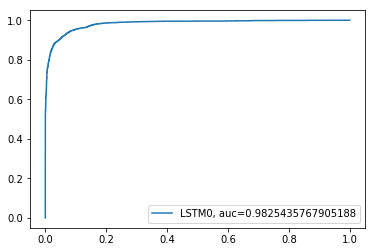

In [28]:
evaluate(x_train, y_train, ensemble_model)

Model: LSTM Model (FAR: 0.095035 FRR: 0.158022 ACC: 0.855300)


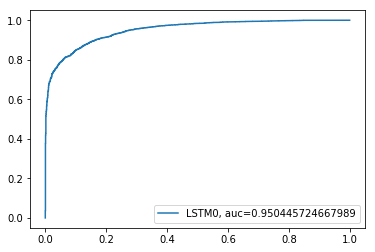

In [29]:
evaluate(x_test, y_test, ensemble_model)

In [30]:
y_tests = y_test.flatten()
y_test_preds = ensemble_model.predict(x_test).flatten()

In [31]:
from sklearn.metrics import r2_score

In [32]:
r2_score(y_tests, y_test_preds)

0.2803533558051837

In [33]:
pd.DataFrame({'pred': y_test_preds, 'act': y_tests}).to_csv('seq-predictions-vs-actual.csv')

FAR: 0.052955 FRR: 0.120228 ACC: 0.894000


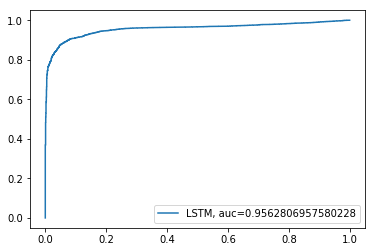

In [38]:
fpr, tpr, thresholds = metrics.roc_curve(y_tests,  y_test_preds)
auc = metrics.roc_auc_score(y_tests, y_test_preds)
plt.plot(fpr,tpr,label="LSTM, auc="+str(auc))

false_accepts = far(y_tests, y_test_preds)
false_rejects = frr(y_tests, y_test_preds)
accuracy = metrics.accuracy_score(y_tests, np.round(y_test_preds))
print('FAR: %4f FRR: %4f ACC: %4f' % (false_accepts, false_rejects, accuracy))
plt.legend(loc=4)
plt.show()

In [35]:
threshold_tests = pd.Series([i/200 for i in range(200)]).apply(lambda x: pd.Series({'t': x, 'tnr': 1-far(y_tests, y_test_preds, x), 'tpr': 1-frr(y_tests, y_test_preds, x)})).set_index('t')

In [38]:
threshold_tests

,tnr,tpr
t,,
0.000,0.000000,1.000000
0.005,0.263357,0.996068
0.010,0.511111,0.983133
0.015,0.613239,0.971972
0.020,0.679433,0.960304
0.025,0.709693,0.952695
0.030,0.731915,0.946734
0.035,0.745154,0.939632
0.040,0.760284,0.933672
